In [8]:
import numpy as np
import pandas as pd
from math import exp
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

df = pd.read_csv('data/dataset.csv')
print(df.shape)

dataset = df.values
#DEFINE TARGET VALUES
X = dataset[:,0:22]
Y = dataset[:,22]
print(Y)

target = []
for y in Y:
    target.append( exp(y))

df['transTarget'] = target

drop_percentage = 0.7
df_dropped_cols = df.copy(deep=True)

for col in df_dropped_cols.columns.values:
    no_rows = df_dropped_cols[col].isnull().sum()
    percentage = float(no_rows) / df_dropped_cols.shape[0]
    if percentage > drop_percentage:
        del df_dropped_cols[col]
        print("Column {} contains {} missing values. This is {} percent. Dropping this column.".format(col, no_rows, percentage))


(5000, 23)
[ 0.0255949   0.05561909  0.00538285 ...  0.12004512  0.04091292
 -0.03892089]
Column architectural_style contains 4978 missing values. This is 0.9956 percent. Dropping this column.
Column building_class contains 4998 missing values. This is 0.9996 percent. Dropping this column.
Column pools contains 4002 missing values. This is 0.8004 percent. Dropping this column.
Column total_area contains 4788 missing values. This is 0.9576 percent. Dropping this column.
Column basement_area contains 4995 missing values. This is 0.999 percent. Dropping this column.
Column number_of_levels contains 3875 missing values. This is 0.775 percent. Dropping this column.


In [9]:
def corr_matrix(data):
    correlation_matrix = data.corr()
    plt.figure(figsize=(20, 20))
    ax = sns.heatmap(correlation_matrix, vmax=1, square=True, annot=True, fmt='.2f', cmap='GnBu',
                     cbar_kws={"shrink": .5}, robust=True)
    for item in ax.get_xticklabels():
        item.set_rotation(45)
    for item in ax.get_yticklabels():
        item.set_rotation(45)
    plt.title('Correlation matrix between the features', fontsize=12)
    plt.show()
# DISPLAY CORRELATED COLUMNS TO TARGET
def display_corr_with_col(df, col):
    correlation_matrix = df.corr()
    correlation_type = correlation_matrix[col].copy()
    abs_correlation_type = correlation_type.apply(lambda x: abs(x))
    desc_corr_values = abs_correlation_type.sort_values(ascending=False)
    y_values = list(desc_corr_values.values)[1:]
    x_values = range(0, len(y_values))
    xlabels = list(desc_corr_values.keys())[1:]
    fig, ax = plt.subplots(figsize=(20, 20))
    ax.bar(x_values, y_values)
    ax.set_title('The correlation of all features with {}'.format(col), fontsize=20)
    ax.set_ylabel('Pearson correlatie coefficient [abs waarde]', fontsize=16)
    plt.xticks(x_values, xlabels, rotation='vertical')
    plt.show()

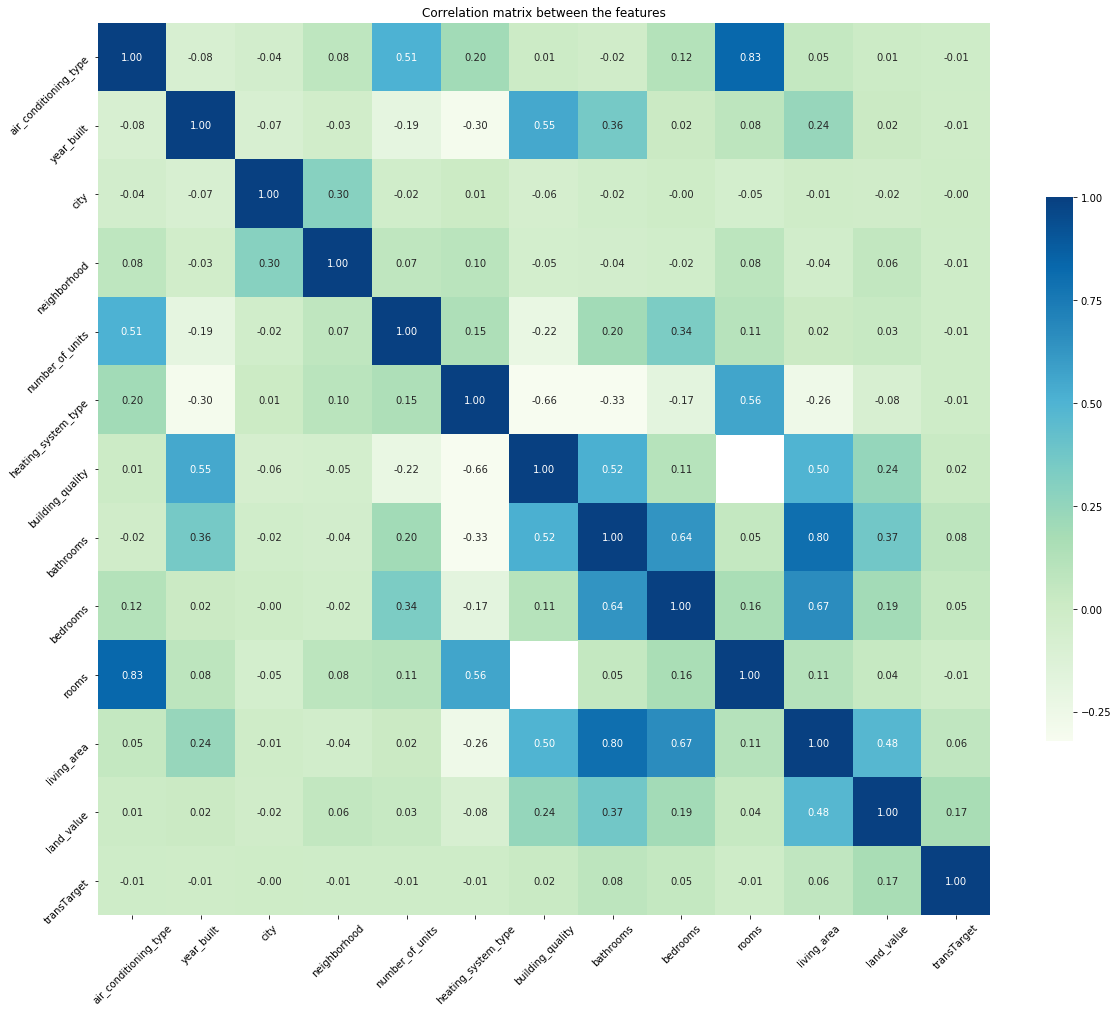

In [10]:
#DROPPING COLUMNS BASED ON CORRELATION ANALYSIS
corr_cols_to_drop = ['garages', 'property_tax', 'structure_value', 'county', 'target']
for col in corr_cols_to_drop:
    del df_dropped_cols[col]

corr_matrix(df_dropped_cols)

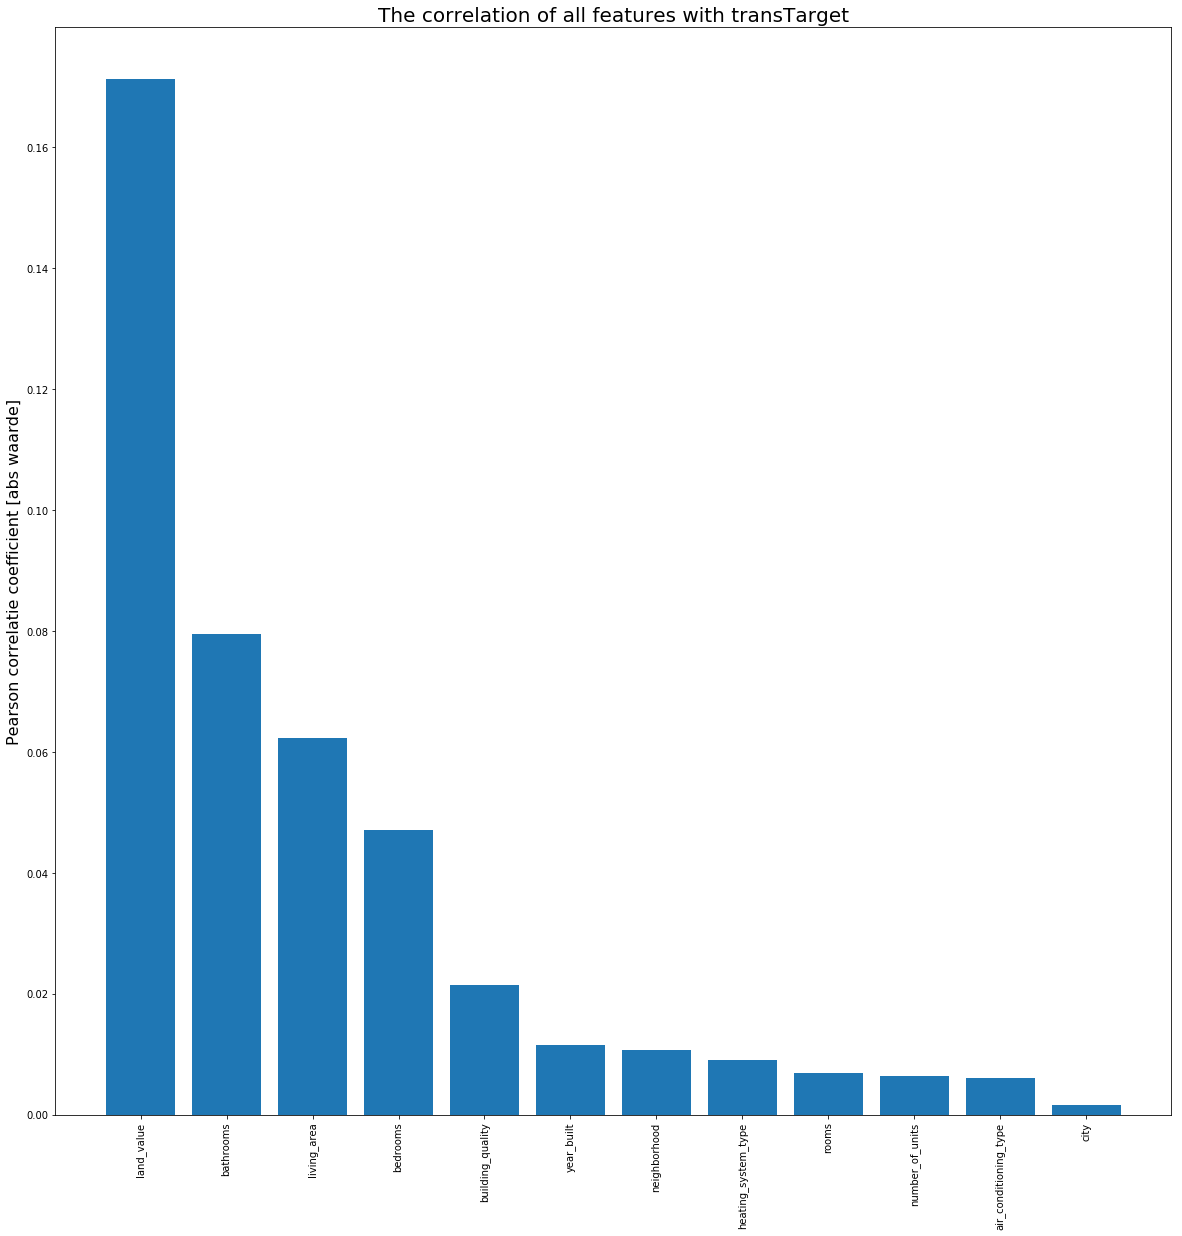

In [11]:
display_corr_with_col(df_dropped_cols, 'transTarget')

In [12]:
#ENCODING
def preprocess(csv_df, cols):
    le = preprocessing.LabelEncoder()
    for col in cols:
        csv_df[col] = le.fit_transform(csv_df[col].factorize()[0])
    x_cols_s = list(csv_df.columns.values)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_df = scaler.fit_transform(csv_df)
    data=pd.DataFrame(scaled_df)
    data.drop([0, 1], axis=1)
    data.columns = x_cols_s
    return data

cols = ['air_conditioning_type','heating_system_type']
df_preprocessed = preprocess(df_dropped_cols, df_dropped_cols)

print(df_preprocessed.shape)

# PREPARE TRAINING AND TESTING DATA
def getValidationSet(df, ratio):
    mask = np.random.rand(len(df)) < ratio
    data = df[mask]
    validation = df[~mask]
    dataset = data.values
    validation_set = validation.values
    X = dataset[:, 0:12]
    Y = dataset[:, 12]
    predict = validation_set[:, 0:12]
    actual = validation_set[:, 12]
    return dataset, validation_set, X, Y, predict, actual
dataset, validation_set, X, Y, predict, actual = getValidationSet(df_preprocessed, 0.9)

#BASE MODEL CREATION METHOD
def baseline_model():
    model = Sequential()
    model.add(Dense(12, input_dim=12, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    #COMPILE
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

seed = 7
numpy.random.seed(seed)
# evaluate model with standardized dataset
estimator = KerasRegressor(build_fn=baseline_model, epochs=100, batch_size=5, verbose=0)

kfold = KFold(n_splits=5, random_state=seed)
results = cross_val_score(estimator, X, Y, cv=kfold)
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

(5000, 13)
Results: -0.04 (0.05) MSE


In [ ]:
from sklearn.model_selection import GridSearchCV
# define the grid search parameters
model = KerasRegressor(build_fn=baseline_model, verbose=0)
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 50, 100]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(X, Y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))